In [9]:
!pip install scanpy==1.10.2


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
import scanpy as sc

In [11]:
# add cell file

In [12]:
# Load and transpose single-cell RNA sequencing data
adata = sc.read_csv('/kaggle/input/covidsmallset/GSM5226574_C51ctr_raw_counts.csv').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [13]:
# Get the shape (dimensions) of the data matrix
adata.X.shape

(6099, 34546)

Doublet Removal

In [14]:
!pip install scvi-tools==1.1.6


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [15]:
import scvi

In [16]:
# Display the AnnData object, showing its main attributes and data
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [17]:
# Filter out genes that are detected in fewer than 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [18]:
!pip install --user scikit-misc

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [19]:
# Identify and keep the top 2000 highly variable genes using the Seurat v3 method
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [20]:
    # setup scvi model to predict doublets and train
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [02:25<00:00,  2.83it/s, v_num=1, train_loss_step=311, train_loss_epoch=325]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:25<00:00,  2.75it/s, v_num=1, train_loss_step=311, train_loss_epoch=325]


In [21]:
#train solo model to predict doublets
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 189/400:  47%|████▋     | 189/400 [01:19<01:28,  2.37it/s, v_num=1, train_loss_step=0.31, train_loss_epoch=0.292] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.267. Signaling Trainer to stop.


In [22]:
# get predictions whether a cell is a doublet or not
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1,0.849880,0.150120,doublet
ATTCACTGTAACAGGC-1,0.963624,0.036376,doublet
TAACTTCCAACCACGC-1,0.664397,0.335602,doublet
TTGGGTACACGACAAG-1,0.898108,0.101892,doublet
AGGCCACAGAGTCACG-1,0.834196,0.165804,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1,0.036316,0.963685,singlet
CACTGGGGTCTACGTA-1,0.002245,0.997755,singlet
CATACTTGTAGAGGAA-1,0.006820,0.993180,singlet
TTTGGTTTCCACGGAC-1,0.001360,0.998640,singlet


In [23]:
# count how many doublets and singlets we have
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1136,1136
singlet,4963,4963


In [24]:
# add new column to data frame to find diffrence between doublet and singlet coulumns
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,0.849880,0.150120,doublet,0.699759
ATTCACTGTAACAGGC-1,0.963624,0.036376,doublet,0.927248
TAACTTCCAACCACGC-1,0.664397,0.335602,doublet,0.328795
TTGGGTACACGACAAG-1,0.898108,0.101892,doublet,0.796216
AGGCCACAGAGTCACG-1,0.834196,0.165804,doublet,0.668392
...,...,...,...,...
CGCCATTGTTTGCCGG-1,0.036316,0.963685,singlet,-0.927369
CACTGGGGTCTACGTA-1,0.002245,0.997755,singlet,-0.995510
CATACTTGTAGAGGAA-1,0.006820,0.993180,singlet,-0.986360
TTTGGTTTCCACGGAC-1,0.001360,0.998640,singlet,-0.997281


In [25]:
# plot distribution of the data frame only from cells that were predicted doublet

In [26]:
import seaborn as sns

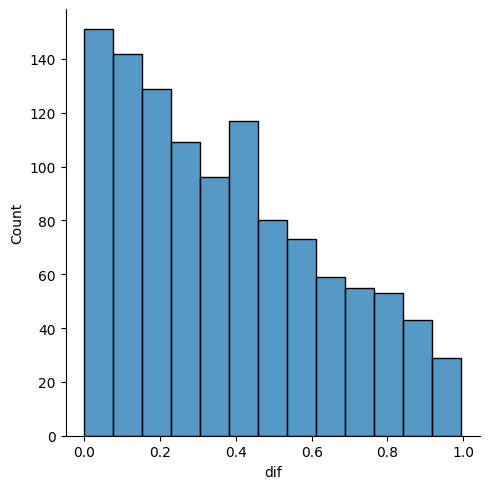

In [27]:
# Plot the distribution of the 'dif' column for rows where 'prediction' is 'doublet'
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [28]:
# Filter rows where 'prediction' is 'doublet' and assign to 'doublets'
doublets = df[(df.prediction == 'doublet')]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,0.849880,0.150120,doublet,0.699759
ATTCACTGTAACAGGC-1,0.963624,0.036376,doublet,0.927248
TAACTTCCAACCACGC-1,0.664397,0.335602,doublet,0.328795
TTGGGTACACGACAAG-1,0.898108,0.101892,doublet,0.796216
AGGCCACAGAGTCACG-1,0.834196,0.165804,doublet,0.668392
...,...,...,...,...
TGTGATGGTCTACAAC-1,0.578676,0.421324,doublet,0.157353
TTCTAGTAGGGCCCTT-1,0.842831,0.157169,doublet,0.685663
ACCTGAAGTGGCTGAA-1,0.607661,0.392339,doublet,0.215323
GGAGGTAGTTAAGCAA-1,0.650385,0.349615,doublet,0.300771


In [29]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [30]:
# reload adata object with fresh adata that was used earlier
adata = sc.read_csv('/kaggle/input/covidsmallset/GSM5226574_C51ctr_raw_counts.csv').T

In [31]:
# add new column in new observation(obs) data frame 
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [32]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [33]:
#filter all cells that were labeled true and keep all cells labeled false
adata = adata[~adata.obs.doublet] # the "~" means you keep the false

In [34]:
adata

View of AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'doublet'

In [35]:
# start preprocessing with doublets removed

Preprocessing

In [36]:
 #label genes that are mitochondria genes 
adata.var['mt'] = adata.var.index.str.startswith('MT-') #annotate all genes with True or False to see if they start with MT

/tmp/ipykernel_30/732268015.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-') #annotate all genes with True or False to see if they start with MT


In [37]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


In [38]:
#import list of ribosomal genes

In [39]:
import pandas as pd

In [40]:
#ribo genes url
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [41]:
# Load ribosomal gene data from URL, skipping the first two rows and without headers
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [42]:
# Extract the first column as a list of ribosomal gene names
ribo_genes[0].values #call list

array(['FAU', 'MRPL13', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12',
       'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A',
       'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24',
       'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3',
       'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36',
       'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL3L',
       'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9',
       'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS12', 'RPS13',
       'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS2',
       'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27',
       'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X',
       'RPS4Y1', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9', 'RPSA',
       'RSL24D1', 'RSL24D1P11', 'UBA52'], dtype=object)

In [43]:
# Annotate ribosomal genes in 'adata.var' by checking if gene names in 'adata.var_names' are in 'ribo_genes'
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values) 

In [44]:
# Display the variable annotations in the AnnData object
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


In [45]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [46]:
# calculate QC metrics or the AnnData object, including mitochondrial and ribosomal genes

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [47]:
adata.var #now have statistics for each gene

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,8,0.001312,99.868831,8.0
AL627309.5,False,False,33,0.005411,99.458928,33.0
AL627309.4,False,False,4,0.000656,99.934415,4.0
AL669831.2,False,False,2,0.000328,99.967208,2.0
LINC01409,False,False,274,0.048697,95.507460,297.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


In [48]:
adata.obs  #now includes mitochondrial stats

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGTACCATGGCCAC-1_1,False,6764,24256.0,153.0,0.630772,55.0,0.226748
ATTCACTGTAACAGGC-1_1,False,6686,19020.0,404.0,2.124080,115.0,0.604627
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
TTGGGTACACGACAAG-1_1,False,4900,15220.0,3.0,0.019711,5.0,0.032852
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [49]:
# sort by number of cells that the gene was found in

adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AP003550.1,False,False,0,0.000000,100.000000,0.0
AC105177.1,False,False,0,0.000000,100.000000,0.0
AL353732.1,False,False,0,0.000000,100.000000,0.0
LINC02665,False,False,0,0.000000,100.000000,0.0
AC013799.1,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4458,3.054271,26.906050,18628.0
NEAT1,False,False,4546,5.314150,25.463191,32411.0
MBNL1,False,False,4554,2.877029,25.332022,17547.0
ZBTB20,False,False,4699,2.601082,22.954583,15864.0


In [50]:
# filter genes that werent in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

In [51]:
# Sort the variable annotations by the number of cells in which each gene is detected
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
OR10G3,False,False,3,0.000492,99.950812,3.0,3
PRKY,False,False,3,0.000492,99.950812,3.0,3
PNCK,False,False,3,0.000492,99.950812,3.0,3
PLXNB3,False,False,3,0.000492,99.950812,3.0,3
AC234781.1,False,False,3,0.000492,99.950812,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4458,3.054271,26.906050,18628.0,4458
NEAT1,False,False,4546,5.314150,25.463191,32411.0,4546
MBNL1,False,False,4554,2.877029,25.332022,17547.0,4554
ZBTB20,False,False,4699,2.601082,22.954583,15864.0,4699


In [52]:
# Sort the observation annotations by total counts per cell
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AGGCATTCATCCGTTC-1_1,False,290,401.0,1.0,0.249377,0.0,0.000000
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377
...,...,...,...,...,...,...,...
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413
TTGGGTACACGACAAG-1_1,False,4900,15220.0,3.0,0.019711,5.0,0.032852
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
ATTCACTGTAACAGGC-1_1,False,6686,19020.0,404.0,2.124080,115.0,0.604627


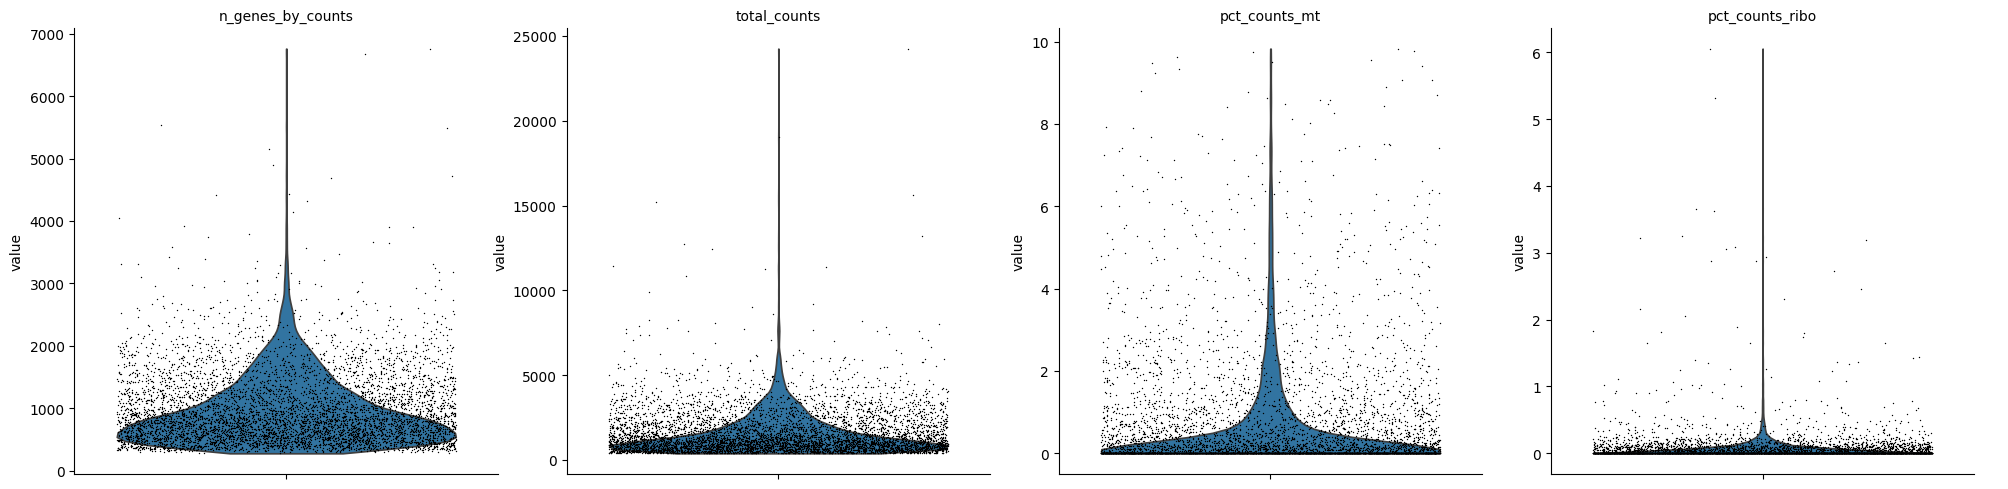

In [53]:
# Create a violin plot for key metrics in the AnnData object, with jitter and in multiple panels
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True) 


In [54]:
#Filtering adata object to get rid of some of the outliers in the data

In [55]:
import numpy as np

In [56]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98) #Filtering down for %98 

In [57]:
upper_lim

2479.08

In [58]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim] #filtering the genes that is above the upper limit

In [59]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,False,2434,6047.0,6.0,0.099223,1.0,0.016537
CTGGCAGGTTCGGTAT-1_1,False,2444,5899.0,307.0,5.204272,5.0,0.084760
ACACCAACACAACGCC-1_1,False,2451,5497.0,0.0,0.000000,3.0,0.054575
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000
ACAAAGATCCACAGGC-1_1,False,2310,5504.0,1.0,0.018169,1.0,0.018169
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [60]:
#filtering for the mitochondrial genes

adata = adata[adata.obs.pct_counts_mt < 20] #Filtering it for the outliyers


In [61]:
# Filtering for the ribosomal genes:

adata = adata[adata.obs.pct_counts_ribo < 2] #Filtering it for the outliyers while checking the previous violin plot


In [62]:
adata

View of AnnData object with n_obs × n_vars = 5960 × 24660
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

Normalization

In [63]:
# normalization to compare cells and genes 

In [64]:
adata.X.sum(axis = 1) #sum of each cell

array([6043., 5895., 5496., ...,  410.,  405.,  410.], dtype=float32)

In [65]:
#normalize count in each cell so total count adds up to same value

In [66]:
# Normalize the total count of each cell to 10,000 unique molecular identifiers (UMIs)
sc.pp.normalize_total(adata, target_sum=1e4) 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [67]:
# Calculate the total count of genes for each cell
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [68]:
sc.pp.log1p(adata) #convert to log counts

In [69]:
adata.X.sum(axis = 1)

array([3155.047  , 3218.0122 , 3416.0486 , ..., 1191.2708 , 1022.75116,
       1162.8785 ], dtype=float32)

In [70]:
#Saving into a raw data as the log counts

adata.raw = adata 

Clustering

In [71]:
# Identify and mark the top 2000 highly variable genes in the AnnData object
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [72]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,8,0.001312,99.868831,8.0,8,False,0.011136,2.697174,1.153160
AL627309.5,False,False,33,0.005411,99.458928,33.0,33,False,0.028855,2.254608,-0.150810
AL627309.4,False,False,4,0.000656,99.934415,4.0,4,False,0.002331,1.702854,-1.776493
LINC01409,False,False,274,0.048697,95.507460,297.0,274,False,0.270478,2.286819,-0.055904
FAM87B,False,False,6,0.000984,99.901623,6.0,6,False,0.006682,1.947490,-1.055700
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,133,0.022627,97.819315,138.0,133,False,0.153974,2.375807,0.206288
AL592183.1,False,False,1003,0.198721,83.554681,1212.0,1003,False,0.875225,2.469386,-0.406744
AC240274.1,False,False,162,0.027382,97.343827,167.0,162,False,0.150268,2.265893,-0.117561
AC007325.4,False,False,4,0.000656,99.934415,4.0,4,False,0.002801,1.579830,-2.138971


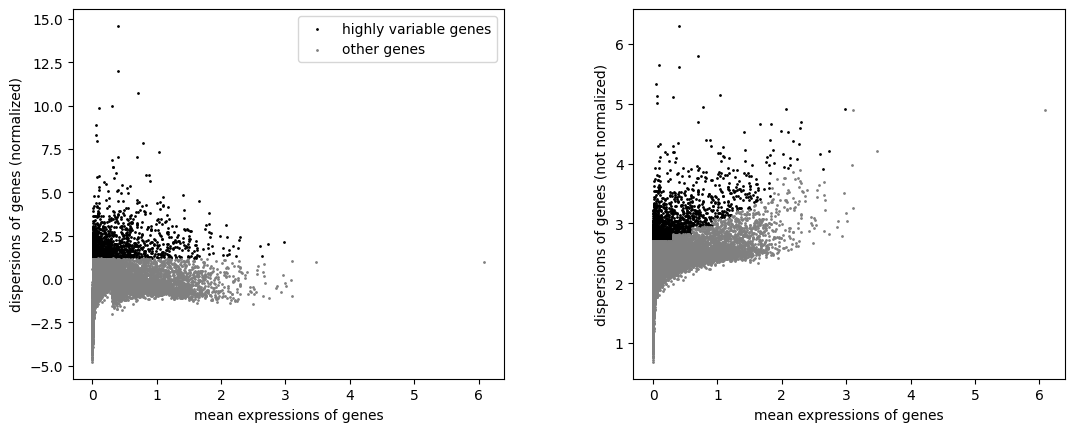

In [73]:
# Plot the highly variable genes identified in the AnnData object
sc.pl.highly_variable_genes(adata) 
# a way of reducing the dimension of the dataset, instead of having 24k genes we did 10 fold reduction as 2000 genes.

In [74]:
# Filter to keep only the highly variable genes
adata = adata[:, adata.var.highly_variable] 

In [75]:
adata

View of AnnData object with n_obs × n_vars = 5960 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [76]:
# Regress out the effects of total counts, mitochondrial, and ribosomal gene percentages from the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

#Regressing out the differences that arises due to the total number of counts, mt counts and ribo counts. 
#This will get rid of some of the variations in the data that are coming from the processing, sample quality,sequencing artificat, etc.


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [77]:
#normalize each genes to the unit variance of that gene

sc.pp.scale(adata, max_value=10)

In [78]:
#Running PCA to further reduce the dimensions of the data 

sc.tl.pca(adata, svd_solver='arpack')


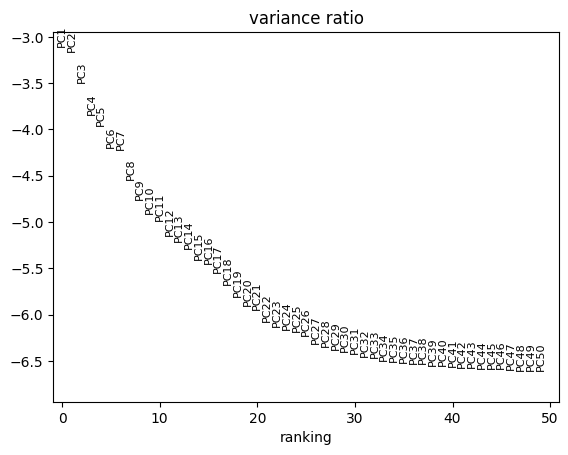

In [79]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) #plot to see how much the pcs contribute to the data

In [80]:
# calculate the neighbors of the cell
sc.pp.neighbors(adata, n_pcs = 30) #using top 30 PC's

In [81]:
adata

AnnData object with n_obs × n_vars = 5960 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [82]:
# Distances and Connectivity is the Neighbors metrices and these would be the main element in making the Clustering 

adata.obsp['connectivities'].toarray() 

array([[0.        , 0.05613268, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05613268, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [83]:
adata.obsp['distances'].toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.20105864,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [84]:
# use umap to project data and convert from 3D to 2D so we can look at it

sc.tl.umap(adata)

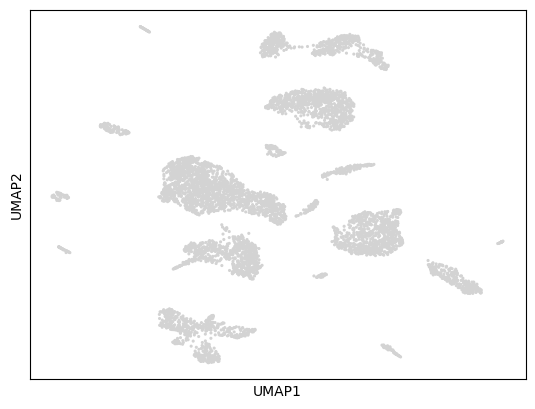

In [85]:
sc.pl.umap(adata)

In [86]:
# assign clusters using leiden algorithim 
!pip install leidenalg

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:0000:0100:01


In [87]:
sc.tl.leiden(adata, resolution = 0.5) #Closer to 1 = more clusters , closer to 0 = less clusters

/tmp/ipykernel_30/2374022656.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5) #Closer to 1 = more clusters , closer to 0 = less clusters


In [88]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
CGTTCTGGTACTAGCT-1_1,False,2434,6047.0,6.0,0.099223,1.0,0.016537,2
CTGGCAGGTTCGGTAT-1_1,False,2444,5899.0,307.0,5.204272,5.0,0.084760,2
ACACCAACACAACGCC-1_1,False,2451,5497.0,0.0,0.000000,3.0,0.054575,1
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,11
ACAAAGATCCACAGGC-1_1,False,2310,5504.0,1.0,0.018169,1.0,0.018169,2
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,6
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,12


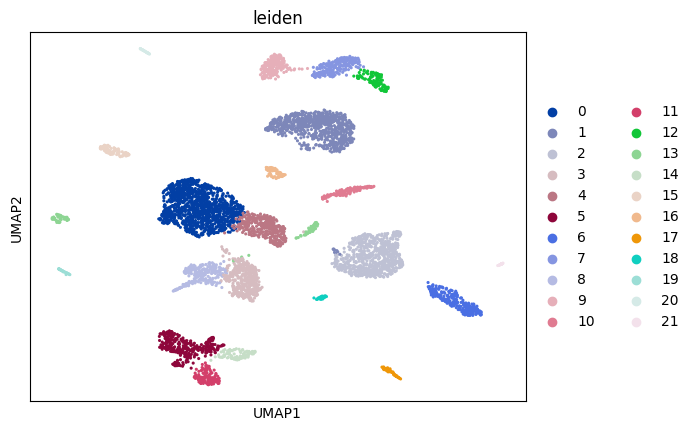

In [89]:
# reploting the umap with based on coloring leiden labels 

sc.pl.umap(adata, color=['leiden'])



Integration

In [90]:
#Integrating all the samples from the research study

In [91]:
def pp(csv_path):
        # Read and transpose the CSV file into an AnnData object
    adata = sc.read_csv(csv_path).T
            # Filter out genes detected in fewer than 10 cells
    sc.pp.filter_genes(adata, min_cells = 10)
        # Identify the top 2000 highly variable genes using the Seurat v3 method
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
        # Set up the AnnData object for the SCVI model
    scvi.model.SCVI.setup_anndata(adata)
        # Initialize and train the SCVI model
    vae = scvi.model.SCVI(adata)
    vae.train()
        # Initialize and train the SOLO model for doublet detection
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
        # Make predictions on doublets and singlets
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
        # Calculate the difference between doublets and singlets
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
        # Re-read the data for further processing
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[1] #'/kaggle/input/rna-seq-data-for-lab/GSM5226574_C51ctr_raw_counts.csv
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet] # Remove doublets from the dataset
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
        # Annotate ribosomal genes
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
        # Calculate quality control metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
        # Apply filtering based on the 98th percentile of gene counts and percentage of mitochondrial and ribosomal counts
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata


In [92]:
import os

# Process each CSV file in the directory and store the results in a list
out = []
for file in os.listdir('/kaggle/input/covidsmallset/'):
    out.append(pp('/kaggle/input/covidsmallset/' + file))

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [01:16<00:00,  5.22it/s, v_num=1, train_loss_step=335, train_loss_epoch=345]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:16<00:00,  5.24it/s, v_num=1, train_loss_step=335, train_loss_epoch=345]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 221/400:  55%|█████▌    | 221/400 [00:48<00:39,  4.58it/s, v_num=1, train_loss_step=0.435, train_loss_epoch=0.326]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.314. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [02:26<00:00,  2.79it/s, v_num=1, train_loss_step=311, train_loss_epoch=323]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:26<00:00,  2.73it/s, v_num=1, train_loss_step=311, train_loss_epoch=323]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [02:50<00:00,  2.32it/s, v_num=1, train_loss_step=0.352, train_loss_epoch=0.287]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:50<00:00,  2.35it/s, v_num=1, train_loss_step=0.352, train_loss_epoch=0.287]


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [02:49<00:00,  2.37it/s, v_num=1, train_loss_step=254, train_loss_epoch=333]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:49<00:00,  2.36it/s, v_num=1, train_loss_step=254, train_loss_epoch=333]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 218/400:  55%|█████▍    | 218/400 [01:47<01:30,  2.02it/s, v_num=1, train_loss_step=0.272, train_loss_epoch=0.307]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.307. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [01:09<00:00,  5.79it/s, v_num=1, train_loss_step=288, train_loss_epoch=304]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:09<00:00,  5.78it/s, v_num=1, train_loss_step=288, train_loss_epoch=304]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 189/400:  47%|████▋     | 189/400 [00:37<00:42,  4.98it/s, v_num=1, train_loss_step=0.246, train_loss_epoch=0.194] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.178. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [01:45<00:00,  3.79it/s, v_num=1, train_loss_step=293, train_loss_epoch=309]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:45<00:00,  3.81it/s, v_num=1, train_loss_step=293, train_loss_epoch=309]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 123/400:  31%|███       | 123/400 [00:37<01:25,  3.25it/s, v_num=1, train_loss_step=0.26, train_loss_epoch=0.247] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.239. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [01:28<00:00,  4.37it/s, v_num=1, train_loss_step=226, train_loss_epoch=258]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:28<00:00,  4.53it/s, v_num=1, train_loss_step=226, train_loss_epoch=258]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 217/400:  54%|█████▍    | 217/400 [00:55<00:46,  3.90it/s, v_num=1, train_loss_step=0.283, train_loss_epoch=0.272]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [01:15<00:00,  5.32it/s, v_num=1, train_loss_step=346, train_loss_epoch=334]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:15<00:00,  5.30it/s, v_num=1, train_loss_step=346, train_loss_epoch=334]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 330/400:  82%|████████▎ | 330/400 [01:11<00:15,  4.61it/s, v_num=1, train_loss_step=0.349, train_loss_epoch=0.268]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.242. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [02:00<00:00,  3.27it/s, v_num=1, train_loss_step=452, train_loss_epoch=472]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:00<00:00,  3.31it/s, v_num=1, train_loss_step=452, train_loss_epoch=472]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 313/400:  78%|███████▊  | 313/400 [01:51<00:31,  2.80it/s, v_num=1, train_loss_step=0.404, train_loss_epoch=0.335]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.335. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [02:16<00:00,  2.86it/s, v_num=1, train_loss_step=293, train_loss_epoch=305]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:16<00:00,  2.93it/s, v_num=1, train_loss_step=293, train_loss_epoch=305]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 157/400:  39%|███▉      | 157/400 [01:04<01:39,  2.45it/s, v_num=1, train_loss_step=0.28, train_loss_epoch=0.236] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.204. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
INFO: GPU available: True (cuda), 

Epoch 400/400: 100%|██████████| 400/400 [01:53<00:00,  3.46it/s, v_num=1, train_loss_step=413, train_loss_epoch=397]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s, v_num=1, train_loss_step=413, train_loss_epoch=397]
INFO     Creating doublets, preparing SOLO model.                                                                  


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 200/400:  50%|█████     | 200/400 [01:04<01:04,  3.10it/s, v_num=1, train_loss_step=0.259, train_loss_epoch=0.298]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.282. Signaling Trainer to stop.


/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [93]:
# Concatenate all processed AnnData objects into a single AnnData object
adata = sc.concat(out)

In [94]:
adata

AnnData object with n_obs × n_vars = 42787 × 34546
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [95]:
adata.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TCTTCCTCAACCGACC-1_12,L05cov,False,2202,2202,4783.0,0.0,0.0,0.0,0.000000
TTGTGTTTCTACCTTA-1_12,L05cov,False,2391,2391,4727.0,0.0,0.0,81.0,1.713560
ATCCCTGTCCAAGCTA-1_12,L05cov,False,2157,2157,4590.0,0.0,0.0,1.0,0.021786
AGGGAGTCAACACGTT-1_12,L05cov,False,2342,2342,4673.0,0.0,0.0,20.0,0.427991
TACACCCGTCTAATCG-1_12,L05cov,False,2368,2368,4565.0,0.0,0.0,60.0,1.314348
...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,C52ctr,False,349,349,403.0,0.0,0.0,0.0,0.000000
TCTCACGAGCTGAAAT-1_2,C52ctr,False,343,343,419.0,0.0,0.0,0.0,0.000000
ATGAAAGAGAGGCGGA-1_2,C52ctr,False,315,315,406.0,0.0,0.0,0.0,0.000000
GATCAGTGTTTCGATG-1_2,C52ctr,False,318,318,424.0,0.0,0.0,0.0,0.000000


In [96]:
# get rid of genes that are in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [97]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [98]:
!pip install scipy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [99]:
from scipy.sparse import csr_matrix

In [100]:
# Convert the data matrix in the AnnData object to a sparse CSR (Compressed Sparse Row) format
adata.X = csr_matrix(adata.X)

In [101]:
# Display data matrix in Anndata
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 38221256 stored elements and shape (42787, 26777)>

In [102]:
adata.write_h5ad('combined.h5ad')

... storing 'Sample' as categorical


In [103]:
###############################################

import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [104]:
adata = sc.read_h5ad('combined.h5ad')
adata


AnnData object with n_obs × n_vars = 42787 × 26777
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [105]:
# Count the number of observations for each sample in the AnnData object
adata.obs.groupby('Sample').count()

/tmp/ipykernel_30/1467336992.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
C51ctr,5960,5960,5960,5960,5960,5960,5960,5960
C52ctr,4415,4415,4415,4415,4415,4415,4415,4415
C53ctr,6928,6928,6928,6928,6928,6928,6928,6928
C54ctr,4284,4284,4284,4284,4284,4284,4284,4284
C55ctr,5565,5565,5565,5565,5565,5565,5565,5565
L01cov,2952,2952,2952,2952,2952,2952,2952,2952
L03cov,3953,3953,3953,3953,3953,3953,3953,3953
L04cov,3401,3401,3401,3401,3401,3401,3401,3401
L05cov,2696,2696,2696,2696,2696,2696,2696,2696


In [106]:
# get rid of genes that arent in at least 100 cells 
sc.pp.filter_genes(adata, min_cells = 100)

In [107]:
adata

AnnData object with n_obs × n_vars = 42787 × 18150
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [108]:
# prep for integration (save raw data as it is now)
adata.layers['counts'] = adata.X.copy()


In [109]:
# Normalize the total counts of each cell to 10,000
sc.pp.normalize_total(adata, target_sum = 1e4)

# Convert the normalized counts to log counts
sc.pp.log1p(adata)

# Store the current state of the AnnData object as raw data
adata.raw = adata

In [110]:
# Display the first few rows of the 'obs' attribute in the 'adata' object
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TCTTCCTCAACCGACC-1_12,L05cov,False,2202,2202,4783.0,0.0,0.0,0.0,0.000000
TTGTGTTTCTACCTTA-1_12,L05cov,False,2391,2391,4727.0,0.0,0.0,81.0,1.713560
ATCCCTGTCCAAGCTA-1_12,L05cov,False,2157,2157,4590.0,0.0,0.0,1.0,0.021786
AGGGAGTCAACACGTT-1_12,L05cov,False,2342,2342,4673.0,0.0,0.0,20.0,0.427991
TACACCCGTCTAATCG-1_12,L05cov,False,2368,2368,4565.0,0.0,0.0,60.0,1.314348


In [111]:
adata

AnnData object with n_obs × n_vars = 42787 × 18150
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [112]:
# setup scvi model
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [113]:
# Initialize an SCVI model using the 'adata' object
model = scvi.model.SCVI(adata)

In [114]:
model.train() 

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 187/187: 100%|██████████| 187/187 [13:09<00:00,  4.23s/it, v_num=1, train_loss_step=2.67e+3, train_loss_epoch=2.93e+3]

INFO: `Trainer.fit` stopped: `max_epochs=187` reached.


Epoch 187/187: 100%|██████████| 187/187 [13:09<00:00,  4.22s/it, v_num=1, train_loss_step=2.67e+3, train_loss_epoch=2.93e+3]


In [115]:
# array that represents our data
adata.obsm['X_scVI'] = model.get_latent_representation()

In [116]:
# Store the normalized expression data from the SCVI model in the 'scvi_normalized' layer of 'adata'
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [117]:
#start clustering 
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [152]:
# Compute UMAP for 'adata' and perform Leiden clustering with a resolution of 0.5
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

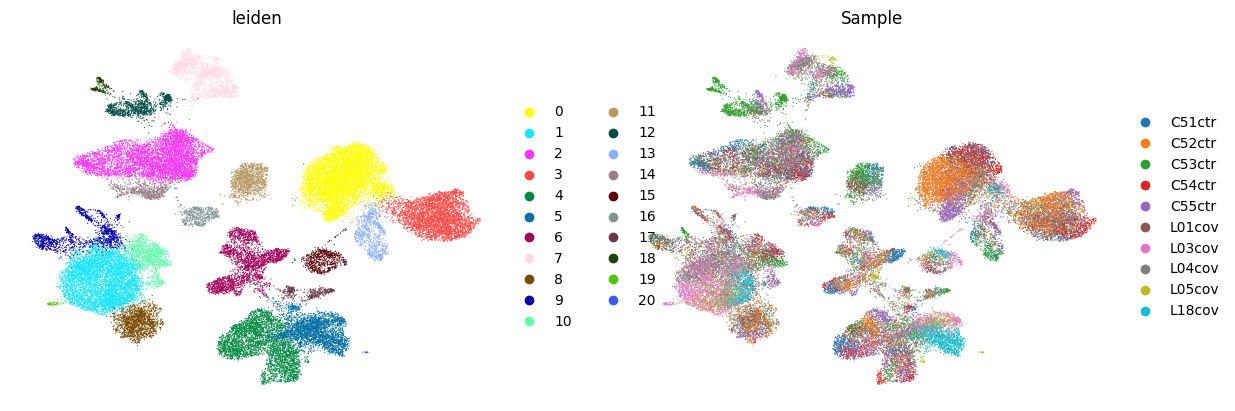

In [153]:
# Plot UMAP for 'adata', coloring by 'leiden' and 'Sample', with no frame around the plot
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [120]:
# Save the 'adata' object to an H5AD file named 'integrated.h5ad'
adata.write_h5ad('integrated.h5ad')

Find Markers/ Label Cell Types

In [163]:
# Perform Leiden clustering on 'adata' with a resolution of 1
sc.tl.leiden(adata, resolution = 1)

In [122]:
# get marker genes based on the leiden and raw data that we saved
sc.tl.rank_genes_groups(adata, 'leiden')

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [135]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#un comment and run for presentation

In [124]:
# Get the ranked genes from 'adata' and filter for significant genes with adjusted p-values < 0.05 and log fold change > 0.5
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,SFTPB,453.587738,8.553801,0.000000,0.000000
1,0,PDE4D,235.215225,5.485852,0.000000,0.000000
2,0,LRRK2,215.493393,7.079282,0.000000,0.000000
3,0,ANK3,204.535355,5.522084,0.000000,0.000000
4,0,ZNF385B,202.302795,7.596748,0.000000,0.000000
...,...,...,...,...,...,...
454052,25,DANT2,2.415299,2.333187,0.031173,0.046682
454053,25,PBX1,2.411439,1.849002,0.031395,0.047011
454054,25,AP3B1,2.408845,1.661964,0.031547,0.047231
454055,25,GPCPD1,2.404928,1.599344,0.031777,0.047572


In [125]:
# Perform differential expression analysis using the SCVI model, grouping by 'leiden' clusters
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|██████████| 26/26 [05:00<00:00, 11.55s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SCN1A,0.9994,0.0006,7.417964,0.000500,7.104174e-06,0.0,0.25,8.727203,8.752800,2.971714,...,0.863104,0.004091,0.454252,0.003170,5.221023,0.026147,True,0 vs Rest,0,Rest
LRRK2,0.9994,0.0006,7.417964,0.006025,2.407922e-04,0.0,0.25,5.868975,5.774150,2.163281,...,10.471366,0.246131,0.943027,0.104831,62.785561,1.669919,True,0 vs Rest,0,Rest
LHFPL3-AS2,0.9994,0.0006,7.417964,0.000884,1.339556e-05,0.0,0.25,8.469174,8.421987,2.838169,...,1.142021,0.006530,0.487075,0.004091,6.769075,0.032827,True,0 vs Rest,0,Rest
ZNF385B,0.9992,0.0008,7.130086,0.004635,1.811034e-04,0.0,0.25,7.657357,7.205801,3.818184,...,8.116060,0.150487,0.921599,0.058878,49.290485,0.909693,True,0 vs Rest,0,Rest
FGG,0.9990,0.0010,6.906745,0.000112,8.324186e-07,0.0,0.25,9.449634,9.399710,3.388750,...,0.127721,0.000406,0.062245,0.000406,0.737394,0.003532,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HECTD4,0.4884,0.5116,-0.046408,0.000171,1.909268e-04,0.0,0.25,-0.126486,-0.146830,0.337695,...,0.642857,0.261194,0.571429,0.205293,3.281947,1.923953,False,25 vs Rest,25,Rest
ANKRD17,0.4878,0.5122,-0.048810,0.000421,4.437595e-04,0.0,0.25,-0.039816,-0.047718,0.346028,...,1.214286,0.643106,0.571429,0.386973,5.988170,4.501647,False,25 vs Rest,25,Rest
PAXBP1,0.4632,0.5368,-0.147467,0.000096,9.529875e-05,0.0,0.25,0.050338,0.040631,0.361148,...,0.214286,0.138221,0.142857,0.119070,1.062347,0.995270,False,25 vs Rest,25,Rest
SETD5,0.4540,0.5460,-0.184522,0.000295,2.787708e-04,0.0,0.25,0.117131,0.083470,0.357939,...,0.500000,0.430531,0.428571,0.306058,2.991017,3.149487,False,25 vs Rest,25,Rest


In [126]:
# Filter the differential expression results for significant genes with FDR < 0.05 and mean log fold change > 0.5
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SCN1A,0.9994,0.0006,7.417964,0.000500,7.104174e-06,0.0,0.25,8.727203,8.752800,2.971714,...,0.863104,0.004091,0.454252,0.003170,5.221023,0.026147,True,0 vs Rest,0,Rest
LRRK2,0.9994,0.0006,7.417964,0.006025,2.407922e-04,0.0,0.25,5.868975,5.774150,2.163281,...,10.471366,0.246131,0.943027,0.104831,62.785561,1.669919,True,0 vs Rest,0,Rest
LHFPL3-AS2,0.9994,0.0006,7.417964,0.000884,1.339556e-05,0.0,0.25,8.469174,8.421987,2.838169,...,1.142021,0.006530,0.487075,0.004091,6.769075,0.032827,True,0 vs Rest,0,Rest
ZNF385B,0.9992,0.0008,7.130086,0.004635,1.811034e-04,0.0,0.25,7.657357,7.205801,3.818184,...,8.116060,0.150487,0.921599,0.058878,49.290485,0.909693,True,0 vs Rest,0,Rest
FGG,0.9990,0.0010,6.906745,0.000112,8.324186e-07,0.0,0.25,9.449634,9.399710,3.388750,...,0.127721,0.000406,0.062245,0.000406,0.737394,0.003532,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRCP,0.9178,0.0822,2.412824,0.000025,3.629991e-05,0.0,0.25,0.581191,0.354465,2.103095,...,0.000000,0.052347,0.000000,0.041849,0.000000,0.330615,True,25 vs Rest,25,Rest
NR2C2AP,0.9178,0.0822,2.412824,0.000004,2.202103e-06,0.0,0.25,1.649993,1.526248,1.645146,...,0.000000,0.002408,0.000000,0.002385,0.000000,0.016556,True,25 vs Rest,25,Rest
TAF9,0.9178,0.0822,2.412824,0.000013,5.954977e-06,0.0,0.25,1.289043,1.284771,0.967678,...,0.000000,0.007201,0.000000,0.007037,0.000000,0.047275,True,25 vs Rest,25,Rest
F5,0.9176,0.0824,2.410176,0.000014,8.798997e-06,0.0,0.25,1.885508,1.662575,2.108959,...,0.000000,0.007061,0.000000,0.006149,0.000000,0.058918,True,25 vs Rest,25,Rest


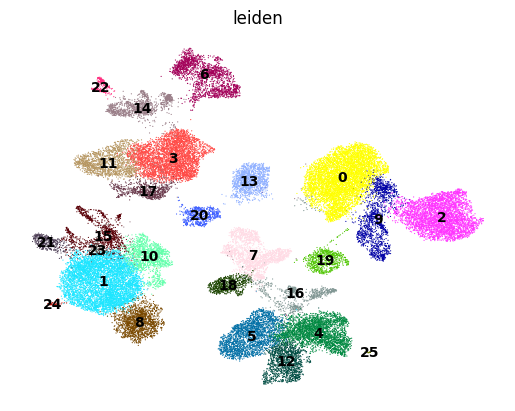

In [164]:
# Plot UMAP for 'adata', coloring by 'leiden' clusters, with no frame around the plot and the legend displayed on the data
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

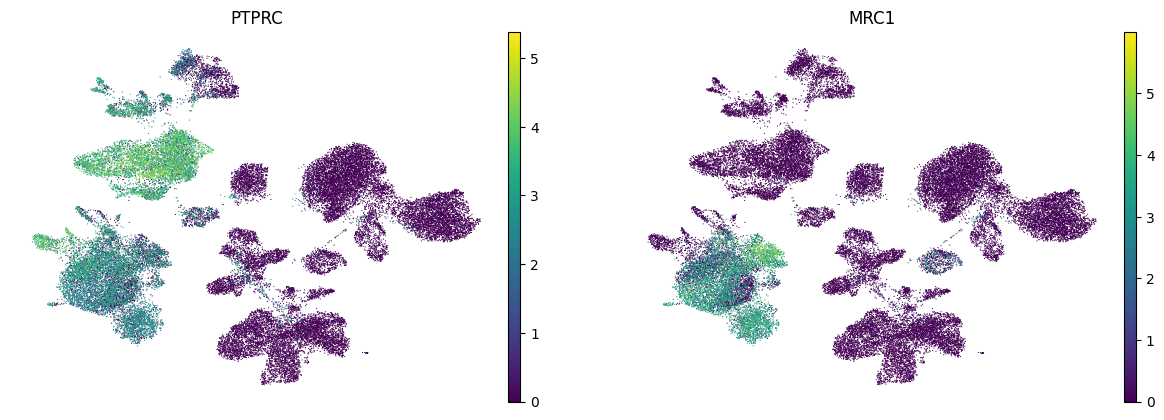

In [173]:
sc.pl.umap(adata, color = ['PTPRC', 'MRC1'], frameon = False)
#, layer = 'scvi_normalized')
           

In [174]:
markers[markers.names == 'MRC1']

,group,names,scores,logfoldchanges,pvals,pvals_adj
18176,1,MRC1,63.535542,3.700555,0.000000e+00,0.000000e+00
145203,8,MRC1,72.727898,4.967995,0.000000e+00,0.000000e+00
181500,10,MRC1,59.251839,5.242872,0.000000e+00,0.000000e+00
272459,15,MRC1,10.801992,1.522478,6.863260e-26,3.677832e-25
345368,19,MRC1,7.614933,1.120929,8.395360e-14,3.955758e-13
417518,23,MRC1,9.930057,2.858065,4.082260e-18,1.584878e-17
435625,24,MRC1,11.306338,4.742648,1.790083e-14,2.964687e-14


In [ ]:
"0":"",
"1":"",
"2":"",
"3":"CD3+ T-cell",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"MRC1",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"CD8+ T-cell",
"18":"",
"19":"",
"20":"",
"21":"",
"22":"",
"23":"",
"24":"CD4+ T-cell",
"25":"",


In [129]:
for x in range(0,26):
    print(f'"{x}":"",')

"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"",
"18":"",
"19":"",
"20":"",
"21":"",
"22":"",
"23":"",
"24":"",
"25":"",
